In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA as sklearnPCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mutual_info_score
import matplotlib.patches as mpatches


In [2]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


#creating a function to calculate MI with mutual_info_score taken from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html
def calc_MI(i, j, bins):
    # from https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html
    c_ij = np.histogram2d(i, j, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_ij)
    return mi

##functions adapted from \
##https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
#essentially removing data points that are not needed
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#to get the top correlations values
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n] 


#adapted the previous function to find the top values of Mutual Informations from a matrix
def get_top_abs(df, n=5):
    au = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au = au.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au[0:n]


In [3]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [4]:
##Question 1

###1a

#copying and dropping unwanted columns                       
foodcontinuous = food.copy()
foodcontinuous = foodcontinuous.drop(['Food ID', 'Survey ID', 'Food Name', 'Survey flag'], axis = 1)


###1b

#using standard scaler
scaler = StandardScaler()
foodscaled = scaler.fit_transform(foodcontinuous)


###1c

#printing all the required output
print("*** \nQ1.c: foodscaled matrix details")
print("Number of rows:", foodscaled.shape[0])
print("Number of columns:", foodscaled.shape[1])
print("Min:", round(foodscaled.min(), 1))
print("Max:", round(foodscaled.max(), 1))
print("Mean:", round(foodscaled.mean(), 1))
print("Standard Deviation:", round(foodscaled.std(), 1))
print("***")



*** 
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Standard Deviation: 1.0
***


/Users/Nico/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Nico/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


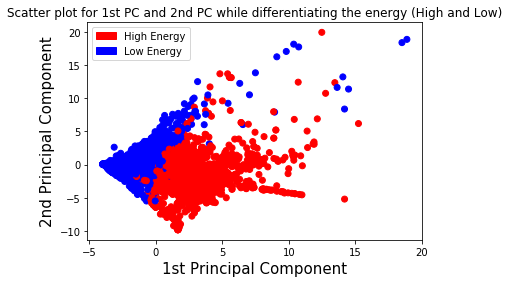

In [5]:
#Question 2


###2a

#creating a new attribute with a condtion on energy
food["EnergyLevel"] = np.where(food["Energy, with dietary fibre (kJ)"] > 1000, 1, 0)

###2b

#conduct PCA
sklearn_pca = sklearnPCA(n_components=2)   #we want just the first two PCs
foodreduced = sklearn_pca.fit_transform(foodscaled)

###2c

#creating the scatter plot
energy = food["EnergyLevel"]

# Using proxy artists to create legend (from matplotlib)
red_points = mpatches.Patch(color="r", label="High Energy")
blue_points = mpatches.Patch(color="b", label="Low Energy")

# Colouring the correct data
col = np.where(energy == 1, "r", "b")

plt.scatter(foodreduced[:,0],foodreduced[:,1], c = col)   #plot the PC's in 2D
plt.xlabel('1st Principal Component', fontsize=15)
plt.ylabel('2nd Principal Component', fontsize=15)
plt.legend(handles = [red_points, blue_points], loc="upper left")

plt.title("Scatter plot for 1st PC and 2nd PC while differentiating the energy (High and Low)")
plt.show()


Question 2d 

The first componenet is supposed to capture the most variability of a feature and the second should be orthogonal to the first, meaning that it captures as much of the remaining variability. As shown by the data points and the colours, the 2 principal components help illustrate the difference between foods with high and low energy. 

Its main advantage is that PCA highlights the most important features / dimensions that help differentiate foods. Reducing the dimension has made the data more simple. It reduces the memory required to process it and allows the data to be easily visualised. The 2 principle components have helped differentiate the energy levels of the foods. However, reducing 53 features into just 2 might be an extreme choice as variability may still exist in the 3rd, 4th, and other principal components. 


/Users/Nico/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Nico/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


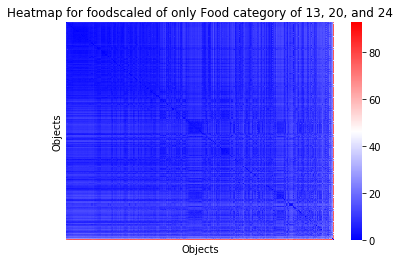

In [6]:
#Question 3


###3a

#creating a new attribute
food['Survey ID'] = food['Survey ID'].astype('str')
food['Food category'] = food['Survey ID'].str.slice(stop=2)

###3b

#selecting appropriate data
foodsample = food.loc[(food['Food category'] == '13')\
                     | (food['Food category'] == '20')\
                     | (food['Food category'] == '24')]

foodsample = foodsample.drop(['Food ID', 'Survey ID', 'Food Name', 'Survey flag', 'Food category', 'EnergyLevel'], axis = 1)

#applying the scaling
scaler = StandardScaler()
foodscaledsample = scaler.fit_transform(foodsample)


###3c

#using VAT() function
RV, C, I = VAT(foodscaledsample)

###3d
x=sns.heatmap(RV,cmap = 'bwr',xticklabels = False,yticklabels = False)
x.set(xlabel = 'Objects', ylabel = 'Objects')
plt.title('Heatmap for foodscaled of only Food category of 13, 20, and 24')
plt.show()





Question 3e 

There are about 2 clusters that are somewhat visible. It is not expected to only have 2 clusters as we have 53 different continuous features and 1622 foods. However, the large amount of data may have made the analysis too complex and variations to not be detected effectively. Using different colormap can be useful when applied to the right context. There are 3 main ones; Sequential: often a single hue to represent ordered data, Diverging: saturation of colours that meet in the middle to highlight data that deviates around an important mean, and Qualitative: the most colorful one used to illustrate unordered or uncorrelated data.

An optimal for ours should be a diverging one; as the data has been scaled with a mean of 0 and standard deviation of 1. A better colormap should take into account the standardisation that has been done to the dataset. Hence, marginal changes in data values can be seen clearly with more extreme changes of color.


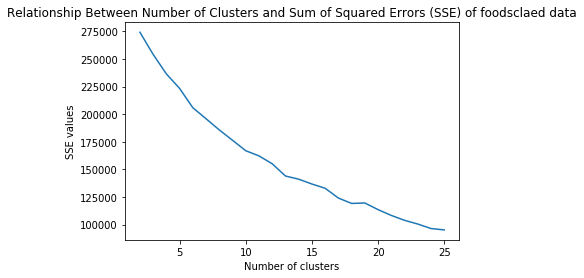

In [7]:
#Question 4

###4a 

#creating an empty dictionary for SSEs
SSE = {}

#looping through the bin lengths 2 to 25
for k in range(2, 26):
    #Use the Kmeans function and inertia
    kmeans = KMeans(n_clusters=k, random_state = 100).fit(foodscaled)
    SSE[k] = kmeans.inertia_ # Inertia=  Sum of squared distances to their nearest cluster center
    #taken from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
plt.figure()
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE values")
plt.title('Relationship Between Number of Clusters and Sum of Squared Errors (SSE) of foodsclaed data')
plt.show()


Question 4b 

The overall trend is decreasing as the number of clusters increases. The elbow can be visibly seen from the graph at about 12 clusters. The trend is expected as we would assume that the more the clusters there are, the lower the sum of squared errors, as there would be more centres. Hence, the shape with the elbow is also expected. 


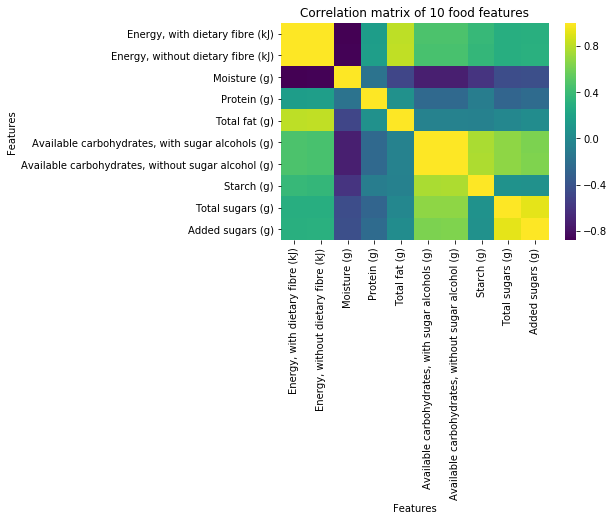

In [8]:
###Question 5


###5a
#creating a new dataframe of only the given features
foodcorr = food[['Energy, with dietary fibre (kJ)',\
                        'Energy, without dietary fibre (kJ)',\
                        'Moisture (g)',\
                        'Protein (g)',\
                        'Total fat (g)',\
                        'Available carbohydrates, with sugar alcohols (g)',\
                        'Available carbohydrates, without sugar alcohol (g)',\
                        'Starch (g)',\
                        'Total sugars (g)',\
                        'Added sugars (g)']]

#using .corr function with pearson correlation as the method
corr = foodcorr.corr(method = 'pearson')

x=sns.heatmap(corr,cmap = 'viridis')
x.set(xlabel = 'Features', ylabel = 'Features')
plt.title("Correlation matrix of 10 food features")
plt.show()


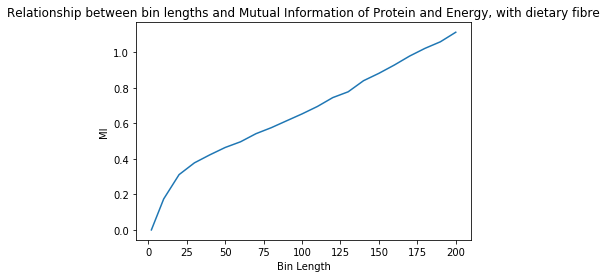

In [9]:
###5b code

#creating a new dataframe of only protein and energy, with dietary fibre
foodmi = food[['Protein (g)', 'Energy, with dietary fibre (kJ)']]


#creating an empty list of MIs
MIS = []
binlength = range(10, 210, 10)

#looping through the required bin lengths and appending the MI result to MIS list
for k in binlength:
    MIS.append(calc_MI(foodmi['Protein (g)'], foodmi['Energy, with dietary fibre (kJ)'], k))

#adding the bin length of 2 and its MI value to MIS list
binlength = list(binlength)
MIScom = [(calc_MI(foodmi['Protein (g)'], foodmi['Energy, with dietary fibre (kJ)'], 2))]
binlengthcom = [2]
MIScom[1:] = MIS
binlengthcom[1:] = binlength

#plotting the graph
plt.plot(binlengthcom, MIScom)
plt.xlabel("Bin Length")
plt.ylabel("MI")
plt.title("Relationship between bin lengths and Mutual Information of Protein and Energy, with dietary fibre")
plt.show()


Question 5b

It has an overall increasing trend. However, the rate of increase suddenly decreases at around bin length of 25. This can be seen from the hump as the steep line suddenly flattens at bin length of 25. The steep increse at the first part explains that increasing the bin length would likely to reveal much more information compared to a shorter bin lengths. However, the effect in the increase of MI from increasing the bin length has become marginal after bin length of 25.

In [10]:
###5c code

#printing the required output using the function
print("Top feature pairs of correlations")
print(get_top_abs_correlations(foodcontinuous, 10))

Top feature pairs of correlations
Alpha-tocopherol (mg)                             Vitamin E (mg)                                        0.999528
Energy, with dietary fibre (kJ)                   Energy, without dietary fibre (kJ)                    0.998608
Beta-carotene (µg)                                Provitamin A (b-carotene equivalents) (µg)            0.995961
Available carbohydrates, with sugar alcohols (g)  Available carbohydrates, without sugar alcohol (g)    0.995466
Added sugars (g)                                  Free sugars (g)                                       0.988894
Total Folates  (µg)                               Dietary folate equivalents  (µg)                      0.985763
Total polyunsaturated fat (g)                     Linoleic acid (g)                                     0.973640
Folic acid  (µg)                                  Dietary folate equivalents  (µg)                      0.958112
Preformed vitamin A (retinol) (µg)                Vitamin A re

In [11]:
###5c code

#creating an empty dataframe with the column and index of that of foodcontinuous' columns
MI_matrix = pd.DataFrame(columns=foodcontinuous.columns.values, index=foodcontinuous.columns.values)

#looping through the possible combinations of all 53 features and finding the Mutual Informations
for i in foodcontinuous:
    for j in foodcontinuous:
        MI_matrix.loc[i, j] = calc_MI(foodcontinuous[i], foodcontinuous[j], 20)
            
#printing the required output using the function
print("Top feature pairs of MIs")
print(get_top_abs(MI_matrix, 10))


Top feature pairs of MIs
Energy, with dietary fibre (kJ)                     Energy, without dietary fibre (kJ)                     2.17666
Available carbohydrates, with sugar alcohols (g)    Available carbohydrates, without sugar alcohol (g)     2.13533
Energy, with dietary fibre (kJ)                     Moisture (g)                                           1.30191
Energy, without dietary fibre (kJ)                  Moisture (g)                                           1.24111
Protein (g)                                         Tryptophan (mg)                                         0.9515
Added sugars (g)                                    Free sugars (g)                                       0.872298
Available carbohydrates, without sugar alcohol (g)  Starch (g)                                            0.762873
Available carbohydrates, with sugar alcohols (g)    Starch (g)                                            0.759233
Total sugars (g)                                    Fre

Question 5c comment 

'Energy, with dietary fibre (kJ) & Energy, without dietary fibre (kJ)', 'Available carbohydrates, with sugar alcohols & Available carbohydrates, without sugar alcohol (g)',  'Added sugars (g) & Free sugars (g)'  are the 3 feature pairs that are on the top 10 lists of both top feature pairs of MI and correlation. The other feature pairs are fairly different. Mutual information is the knowledge one variable gives us information about the other variable. On the other hand, correlation means that a change in one variable is directly related to a change in the other variable. Correlation is usually used for linear relationships and causality. Whereas mutual information can help analyse non-linear relationships.

                               
   


*** 
Q6.a: Train Test Split Results
X_train matrix: (4592, 53)
y_train labels: (4592,)
X_test matrix: (1148, 53)
y_test labels: (1148,)
***


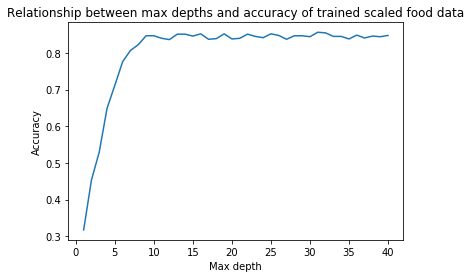

In [12]:
##Question 6


###6a

##randomly select 80% of data to be training and the rest to be testing
classlabel = food['Food category']
X_train, X_test, y_train, y_test = train_test_split(foodscaled, classlabel, train_size=0.80, test_size=0.20, random_state=42)

#printing all the required output
print("*** \nQ6.a: Train Test Split Results")
print("X_train matrix:", X_train.shape)
print("y_train labels:", y_train.shape)
print("X_test matrix:", X_test.shape)
print("y_test labels:", y_test.shape)
print("***")

###6b
#initializing the max depth values
max_depth = range(1, 41)
Acc = []

#looping through to calculate the accuracy score while varying the max depth
for k in max_depth:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=k)  
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    Acc.append(accuracy_score(y_test, y_pred))
    
    
plt.plot(max_depth, Acc)
plt.title('Relationship between max depths and accuracy of trained scaled food data')
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.show()

Question 6c comment here
c) Comment on the shape of the plot in Part c). Suggest reasons for the shape of the plot
and any local peaks.

The overall trend is increasing until it flattens when the max depth reaches its peak at about 8. The trend is pretty stable after it peaks with little variation about the peak of accuracy of 0.9. Local peaks are just variation of the extra max depth after 8. It seems that the variation is a result of the little or no information that a marginal max depth would give to the decision tree.

In [13]:
#Question 7

###7a

#using the K-NN function with number of nearest neighbors = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

#running the predictions
y_predtest=knn.predict(X_test)
y_predtrain=knn.predict(X_train)

#printing all the required output
print("*** \nQ7.a: Food category prediction using k-NN (k=1)")
print("Train accuracy:", round(accuracy_score(y_train, y_predtrain)*100, 1), "%")
print("Test accuracy", round(accuracy_score(y_test, y_predtest)*100, 1), "%")
print("***")


##7b

#using the K-NN function with number of nearest neighbors = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#running the predictions
y_predtest=knn.predict(X_test)
y_predtrain=knn.predict(X_train)

#printing all the required output
print("*** \nQ7.b: Food category prediction using k-NN (k=3)")
print("Train accuracy:", round(accuracy_score(y_train, y_predtrain)*100, 1), "%")
print("Test accuracy", round(accuracy_score(y_test, y_predtest)*100, 1), "%")
print("***")


*** 
Q7.a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy 89.5 %
***
*** 
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy: 93.3 %
Test accuracy 88.0 %
***


Question 7c comment 

Accuracy seems to be better for both train and test data when nearest neighbor is equal to one. However, the train accuracies for both 3 and 1 nearest neighbors are higher than that of their test accuracies. The train accuracy when nearest neighbor is equal to one is 100% because the closest point to any training data is the data itself. Hence, the prediction is always correct. 

Question 7d comment 

The result is overoptimistic because the steps that we have taken were incorrect. We scaled the continuous data first before splitting it to train and test data. Hence, there is a leak of information from the test data in the scaled training set. To avoid this, we need to split the data into training and testing data first, then scale the training set by itself. The testing data needs to be scaled with the the fitted scaler of the training dataset (the same mean and standard devitaion). This will make sure that the testing data is consistent with the transformed training dataset. Hence, prediction can be done true to the real distribution of the data.



In [14]:
#8 

#generating new features, interaction terms
foodcontinuous.apply(pd.to_numeric)

interterms = pd.DataFrame()

#Lopping through possible combinations and updating the dataframe interterms
for i in foodcontinuous:
    for j in foodcontinuous:
        i_j = "{} * {}".format(i,j)
        j_i = "{} * {}".format(j,i)
        j_j = "{} * {}".format(j,j)
        if (j_j != i_j): 
            if (j_i not in interterms.columns and i_j not in interterms.columns ):
                interterms[i + " * " + j] = foodcontinuous[i] * foodcontinuous[j]
                                                                                                     
                                                                                             

        

In [15]:
#checking the new dataframe, interterms
interterms [:5]

,"Energy, with dietary fibre (kJ) * Energy, without dietary fibre (kJ)","Energy, with dietary fibre (kJ) * Moisture (g)","Energy, with dietary fibre (kJ) * Protein (g)","Energy, with dietary fibre (kJ) * Total fat (g)","Energy, with dietary fibre (kJ) * Available carbohydrates, with sugar alcohols (g)","Energy, with dietary fibre (kJ) * Available carbohydrates, without sugar alcohol (g)","Energy, with dietary fibre (kJ) * Starch (g)","Energy, with dietary fibre (kJ) * Total sugars (g)","Energy, with dietary fibre (kJ) * Added sugars (g)","Energy, with dietary fibre (kJ) * Free sugars (g)",...,C20:5w3 Eicosapentaenoic (mg) * C22:5w3 Docosapentaenoic (mg),C20:5w3 Eicosapentaenoic (mg) * C22:6w3 Docosahexaenoic (mg),C20:5w3 Eicosapentaenoic (mg) * Total long chain omega 3 fatty acids (mg),C20:5w3 Eicosapentaenoic (mg) * Total trans fatty acids (mg),C22:5w3 Docosapentaenoic (mg) * C22:6w3 Docosahexaenoic (mg),C22:5w3 Docosapentaenoic (mg) * Total long chain omega 3 fatty acids (mg),C22:5w3 Docosapentaenoic (mg) * Total trans fatty acids (mg),C22:6w3 Docosahexaenoic (mg) * Total long chain omega 3 fatty acids (mg),C22:6w3 Docosahexaenoic (mg) * Total trans fatty acids (mg),Total long chain omega 3 fatty acids (mg) * Total trans fatty acids (mg)
0,160801,22696.6,6656.6,80.2,2606.5,2606.5,2606.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,835146,10790.0,19637.8,5934.5,16724.5,16724.5,16724.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1478297,11063.9,14396.4,8931.1,53986.5,53986.5,41323.0,12663.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1681647,11239.8,17724.3,24208.8,29540.5,29540.5,14986.4,14554.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2131415,10381.8,22179.3,26426.4,46560.8,46560.8,30201.6,16359.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


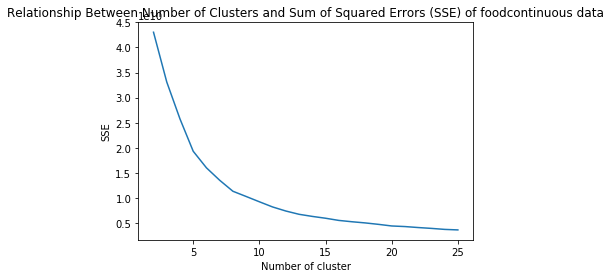

In [16]:
#8 continued

#generating a new feature, cluster term

#First, I plot SSE and the bin lengths to find the elbow
sse = {}
for k in range(2, 26):
    kmeans = KMeans(n_clusters=k).fit(foodcontinuous)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Relationship Between Number of Clusters and Sum of Squared Errors (SSE) of foodcontinuous data')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [17]:
#8 continued

#creating the cluster of 7 series called cluster7 where the elbow is using K-Means

km = KMeans(n_clusters = 7)
new = foodcontinuous._get_numeric_data().dropna(axis=1)
cluster7 = km.fit_predict(new)


In [18]:
#8 continued

#combining dataframes foodcontinuous, interterms, and cluster7

combined = pd.concat([foodcontinuous, interterms] , axis=1)
combined['cluster7'] = cluster7

#to visualise the datafame
combined[:5]

,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol (g)",Starch (g),Total sugars (g),Added sugars (g),...,C20:5w3 Eicosapentaenoic (mg) * C22:6w3 Docosahexaenoic (mg),C20:5w3 Eicosapentaenoic (mg) * Total long chain omega 3 fatty acids (mg),C20:5w3 Eicosapentaenoic (mg) * Total trans fatty acids (mg),C22:5w3 Docosapentaenoic (mg) * C22:6w3 Docosahexaenoic (mg),C22:5w3 Docosapentaenoic (mg) * Total long chain omega 3 fatty acids (mg),C22:5w3 Docosapentaenoic (mg) * Total trans fatty acids (mg),C22:6w3 Docosahexaenoic (mg) * Total long chain omega 3 fatty acids (mg),C22:6w3 Docosahexaenoic (mg) * Total trans fatty acids (mg),Total long chain omega 3 fatty acids (mg) * Total trans fatty acids (mg),cluster7
0,401,401,56.6,16.6,0.2,6.5,6.5,6.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1079,774,10.0,18.2,5.5,15.5,15.5,15.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,1333,1109,8.3,10.8,6.7,40.5,40.5,31.0,9.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1441,1167,7.8,12.3,16.8,20.5,20.5,10.4,10.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,1573,1355,6.6,14.1,16.8,29.6,29.6,19.2,10.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [ ]:
#creating a Mutual Information matrix and find the top 10 feature pairs
MI_matrix_combined = pd.DataFrame(columns=combined.columns.values, index=combined.columns.values)
#with bin length of 20
for i in combined:
    for j in combined:
        MI_matrix_combined.loc[i, j] = calc_MI(combined[i], combined[j], 20)
            


print("Top feature pairs of MIs")
top10 = get_top_abs(MI_matrix_combined, 10)
print(top10)

In [ ]:
#8 continued

#creating 10 top features from the top feature pairs
topfeature = combined[top10.index[0][0], top10.index[0][1], top10.index[1][0], top10.index[1][1]\
                      top10.index[2][0], top10.index[2][1], top10.index[3][0], top10.index[3][1]\
                      top10.index[4][0], top10.index[4][1]]

#splitting of dataset into training, 80 % and testing 20%
classlabel = food['Food category']
X_train, X_test, y_train, y_test = train_test_split(topfeature, classlabel, train_size=0.80, test_size=0.20)

#scale training data first, followed by the scaling of testing data using the fitted value of training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#using the K-NN function with number of nearest neighbors = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

#running the predictions
y_predtest = knn.predict(X_test_scaled)
y_predtrain = knn.predict(X_train_scaled)

#printing the prediction accuracy on training and testing
print("***")
print("Train accuracy:", round(accuracy_score(y_train, y_predtrain)*100, 1), "%")
print("Test accuracy", round(accuracy_score(y_test, y_predtest)*100, 1), "%")
print("***")


Question 8 discussion 

First, as instructed by the question, I have created interaction terms between different features only. I conditioned  my loop so that it generates only new interaction terms and not an interaction of a feature and itself. An ineraction feature of a feature with itself will likely to have a high Mutual Information score. Hence, i did not include it. Next, I loop through different K for K-means, calculate the SSEs and plot them. The graph demonstrates that the elbow is at about 7. Thus, I used K Means with K=7 for my only cluster feature named "cluster7". Then, I combined all the features of foodcontinuous, interaction terms, and cluster7 before I finally created a Mutual Information matrix and find the top 10 feature pairs. I used the top feature pairs for prediction using K Nearest Neighbors. It is also important to note that I split the data into training and testing first before scaling and fitting them. A prediction is finally done to get the accuracy score.

Feature selection and generation will definitely deliver an accuracy boost. While adding more features will certainly add complexity, it also gives extra information. The more information there is, the more accurate a prediction can be. However, too many features can make a model too complicated and unnecessary. This is particularly true when the added features correlate too much with other features in the model. Hence, an additional feature may only give a marginal effect on increasing the accuracy of the model. A feature can also be misleading, especially when we are using K nearest neighbor as a redundant attribute can create a skewed model. Too many features can also lead to an overfitting model.

What we did, to compute mutual information of the feature pairs, is one of the ways to rank the additional information a feature can give. This is a useful tool for model builders to have. Feature selection methods can then be really effective as the extra information is quantifiable and can be compared. Other than improving the accuracy if the right features are chosen, it also helps the data to be trained faster. The model can also be interpreted easily as it is simpler. Another important reason feature selection can help increase accuracy is that it helps reduce noise in dataset.

